[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/algorithms_from_scratch/gradient_boosting.ipynb) 

# Gradient Boosting From Scratch

The general idea behind boosting is to combine multiple weak learners to create a strong learner. The weak learners are typically decision trees, but can be any other type of model. The key idea behind gradient boosting is to set the target variable as the residuals of the previous model. This way, the next model is trained to predict the residuals of the previous model. This process is repeated for as many iterations as necessary. The final model is the sum of all the models.

The algorithm can be summarized as follows:
1. Initialize the model with a constant value, typically the mean of the target variable.
2. For each iteration:
    1. Calculate the residuals of the previous model.
    2. Fit a weak learner to the residuals.
    3. Update the model by adding the weak learner to the ensemble.
3. The final model is the sum of all the weak learners.

The algorithm can be used for both regression and classification. In the case of regression, the residuals are simply the difference between the predicted value and the actual value. In the case of classification, the residuals are the negative gradient of the loss function with respect to the predicted value. The loss function is typically the log loss for binary classification.

The notebooks showcases a simple - much simplified - from scratch implementation in Python. We first demonstrate a regression version using synthetic data. Next, we consider a classification version, using again synthetic data. 

**Acknowledgements**:
Parts of our code draw heavily on this [post](https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-4a3d9077367), and adjust it for this notebook. 

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Regression setting

### Synthetic data for univariate regression
We create synthetic data for a univariate regression problem. Using only one features allows for easy visualization. We sample $X$ from a normal distribution and then obtain the target $y$ by assuming *ground-truth values* for an intercept and a regression coefficient, and adding some noise.

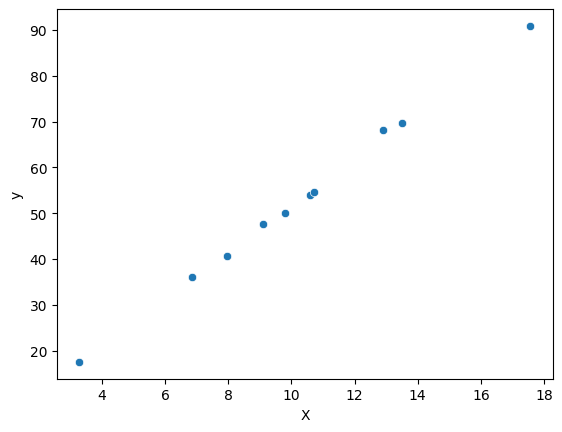

Shape of X: (10, 1)
Shape of y: (10, 1)


In [14]:
# Sample X from a normal distribution
n = 10
location = 10
sd = 3

X = np.random.normal(loc=location, scale=sd, size=n).reshape(-1,1)  # reshape to make it a column vector, i.e. n x 1 instead of a 1-D array

# Generate target variable assuming linear additive relationship
intercept = 2  # chosen arbitrarily
beta = 5  # chosen arbitrarily

y = intercept + beta*X + np.random.normal(size=n).reshape(-1,1)  # as above

# Plot the data 
sns.scatterplot(x=X.flatten(), y=y.flatten())
plt.xlabel("X")
plt.ylabel("y")
plt.show()

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


### Three boosting steps
We will fit three boosting steps. The first model is a simple mean of the target variable. The second model is a shallow decision tree fitted to the residuals of the first model. The third model is a decision tree fitted to the residuals of the ensemble consisting of base model 1 and base model 2. The final model is the sum of all three models.

We consider a learning rate of 0.5, which is a hyperparameter that controls the contribution of each model to the ensemble. A smaller learning rate will require more iterations to converge, but will typically result in a better model. For this example, we will use a learning rate of 0.5, which allows us to emphasize the change of the ensemble forecast across iterations.

#### Step 1

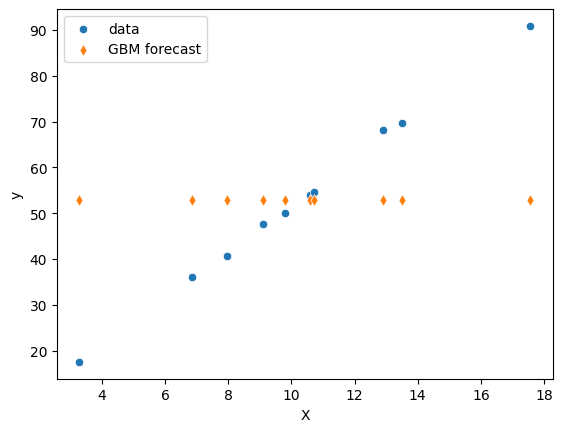

In [37]:
# First base model, i.e., constant prediction
H0 = np.repeat(np.mean(y), X.shape[0]).reshape(-1,1)  # column vector of the same size as y, with all elements equal to the mean of y

# Plot the data plus the ensemble forecast
def plot_gbm_step(X, y, H):
    sns.scatterplot(x=X.flatten(), y=y.flatten(), label="data")
    sns.scatterplot(x=X.flatten(), y=H.flatten(), label="GBM forecast", marker="d")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend(loc="best")
    plt.show()

plot_gbm_step(X, y, H0)


In [19]:
# calc residuals and MSE
e0 = y-H0

print("MSE of H0 is {}".format( np.mean(e0**2 )))

MSE of H0 is 368.50827771082277


#### Step 2

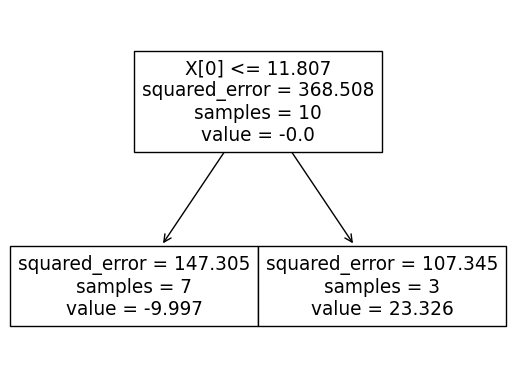

In [20]:
# Train base model 2 using (X, e0). Note that we fit the model to the residuals of H0 
from sklearn.tree import DecisionTreeRegressor, plot_tree

tree = DecisionTreeRegressor(max_leaf_nodes=2)  # shallow tree, i.e., stump
tree.fit(X, e0)
plot_tree(tree)
plt.show()

In [21]:
# Calculate base model forecast 
h1 = tree.predict(X).reshape(-1,1)
h1

array([[-9.99695823],
       [-9.99695823],
       [-9.99695823],
       [23.32623586],
       [-9.99695823],
       [23.32623586],
       [-9.99695823],
       [23.32623586],
       [-9.99695823],
       [-9.99695823]])

In [38]:
# Set learning rate
eta = 0.5

# Calculate ensemble forecast
H1 = H0 + eta*h1  # ensemble in step 2

e1 = y - H1  # residuals after step 2
print("MSE of H1 is {:.3f} c.f. H0 of {:.3f}".format( np.mean(e1**2 ), np.mean(e0**2 )))

MSE of H1 is 193.615 c.f. H0 of 368.508


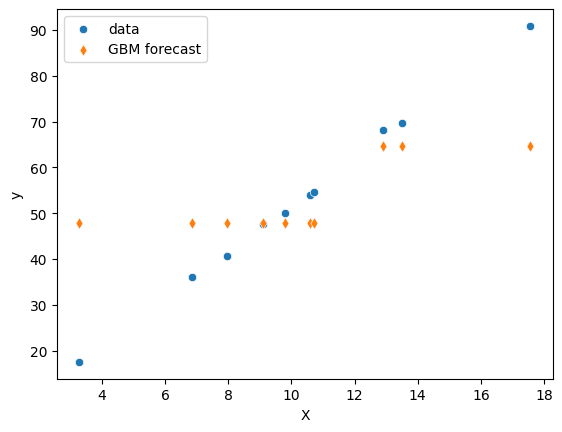

In [39]:
# Plot current solution
plot_gbm_step(X, y, H1)

Note how the first "ensemble" forecast a constant value whereas the ensemble in step 2 forecasts two distinct numbers. It is still a bad forecast but illustrates how the forecasts gradually becomes more aligned with the actual target values. Let's do one more step. 

#### Step 3

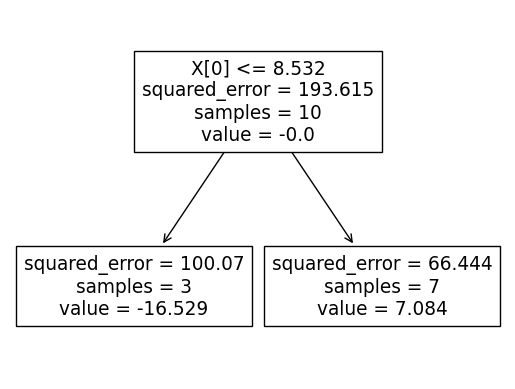

In [40]:
# Fit model 2 to residuals of H1
tree2 = DecisionTreeRegressor(max_leaf_nodes=2)
tree2.fit(X, e1)
plot_tree(tree2);

MSE of H2 is 105.803 c.f. H1 of 193.615


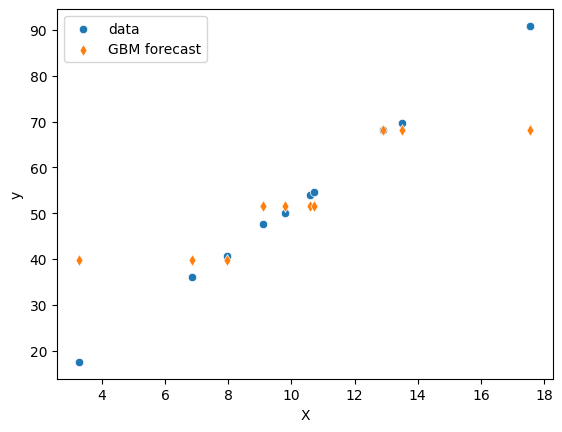

In [41]:
# Update our ensemble
H2 = H1 + eta*tree2.predict(X).reshape(-1, 1)

e2 = y - H2  # residuals after step 3


print("MSE of H2 is {:.3f} c.f. H1 of {:.3f}".format( np.mean(e2**2 ), np.mean(e1**2 )))

# Plot status
plot_gbm_step(X, y, H2)

Let's complete the demo by wrapping-up the core steps of the algorithm in a function and doing a few more boosting iterations.

MSE after (before) boosting step is 62.687 (105.803)
MSE after (before) boosting step is 26.323 (62.687)
MSE after (before) boosting step is 16.683 (26.323)
MSE after (before) boosting step is 10.445 (16.683)
MSE after (before) boosting step is 5.192 (10.445)


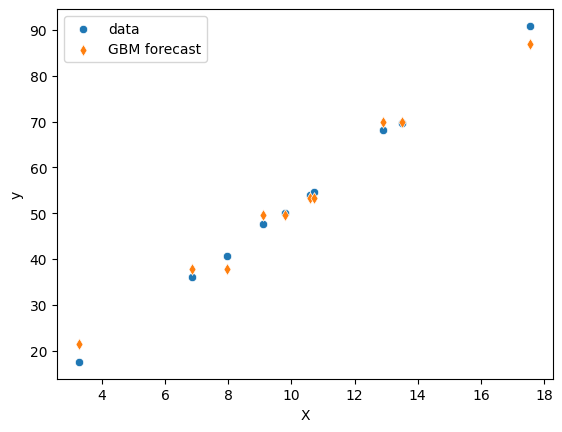

In [44]:
def boosting_iteration(X, y, H, eta, max_leaf_nodes=2):
    """
    Perform one iteration of boosting as illustrated above.
    """
    # Calculate residuals
    residuals = y - H
    
    # Train a decision tree on the residuals
    tree = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
    tree.fit(X, residuals)
    
    # Predict the residuals
    h = tree.predict(X).reshape(-1, 1)
    
    # Update the ensemble
    H_new = H + eta * h
    
    print("MSE after (before) boosting step is {:.3f} ({:.3f})".format( np.mean((y-H_new)**2 ), np.mean(residuals**2 )))

    return H_new, tree

# Initialize the ensemble with H2
H = H2

# Perform five more boosting iterations
for i in range(5):
    H, tree = boosting_iteration(X, y, H, eta)

# Plot the final ensemble
plot_gbm_step(X, y, H)

## Classification setting

### Synthetic data for binary classification
We create synthetic data for a binary classification problem using the `make_blobs` function.

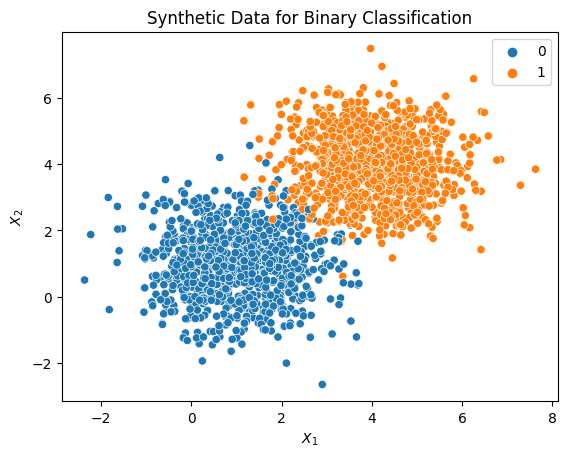

In [53]:
from sklearn.datasets import make_blobs

# Create synthetic dataset using make_blobs
X, y = make_blobs(n_samples=2000, centers=[[1, 1], [4, 4]], cluster_std=1.0, random_state=888, n_features=2)

# Plot the data
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Synthetic Data for Binary Classification")
plt.show()

### GBM Classifier

To begin gradient boost, we first need a loss function to quantify the difference between the predicted and true y values. This loss function must be differentiable to obtain the gradient. This loss function will determine how the function and its derivative (the gradient) creates future stumps for our gradient boost forest.

In [54]:
def compute_loss(y, pred_y): 
    return ((y - pred_y) ** 2) / 2

In [55]:
def loss_gradient(y, pred_y): 
    return -(y-pred_y)

Now that we have our loss and gradient functions, we can begin with the gradient boost algorithm. The first step in the algorithm is to create an initial prediction. Generally, this is the mean of the labels. Next, residuals are calculated by using the `loss_gradient` function and a shallow single level decision tree or decision 'stump' is created based on these residuals. Residuals are then recalculated and this process repeats iteratively.

In [56]:
from sklearn.tree import DecisionTreeRegressor 

def gradient_boost_algorithm(X, y, iter=10): 
    forest_of_stumps = [] 
    pred_y = np.array([y.mean()]*len(y))  # Predict mean for all observations
    pred_y_initial = pred_y 
    print(compute_loss(y, pred_y).mean()) 
    for i in range(iter): 
        residuals = -loss_gradient(y, pred_y)  # Calculate residuals using the gradient function
        stump = DecisionTreeRegressor(max_depth=1)
        stump.fit(X, residuals)  # Feed data and residuals to the decision tree function (stump since it has a depth of only 1)
        forest_of_stumps.append(stump)  # Add this tree to the forest
        new_pred_y = stump.predict(X)  # Make new predictions and repeat this process over the specified number of iterations
        pred_y = pred_y + new_pred_y 
        print(compute_loss(y, pred_y).mean())
    return forest_of_stumps, pred_y_initial

The final function will be to predict classes using our algorithm. We will first run new observations through our forest of stumps sequentially and add their predictions together. At this point, the tree will return probabilities that each observation will be of class `1`. If we want a class prediction rather than probabilities of class `1`, we can compare each prediction to some threshold value (defaulted at `0.5`). Predictions over the threshold will be considered class `1` predictions while all others will be class `0`.

In [57]:
def gbm_predict(forest_of_stumps, pred_y_initial, X, predict_class=False, threshold=0.5): 
    pred_y = np.array([pred_y_initial[0]]*len(X))
    for stump in forest_of_stumps: 
      pred_y = pred_y + stump.predict(X)  # Navigate the forest sequentially adding the predictions from each stump along the way
      pred_y = np.where(pred_y<0, 0, pred_y)
      pred_y = np.where(pred_y>1, 1, pred_y) 
    if predict_class:
      pred_y = pred_y > threshold
      pred_y = np.where(pred_y==False, 0, pred_y)
      pred_y = np.where(pred_y==True, 1, pred_y) 
    return pred_y

Now we can train our model using these functions. Each loop within the function will print the mean of the loss function so we can verify that it is actually decreasing. You can adjust iteration number to allow a larger forest of stumps in the gradient boost forest.

In [59]:
stumps, pred_y_initial = gradient_boost_algorithm(X, y, iter=10)

0.125
0.027745495351330588
0.022953915483136734
0.020272355298301802
0.01804355943886055
0.016886861377274492
0.015933793139821656
0.015434091800149947
0.015054535614007183
0.014868441217269065
0.014548019433041801


In [60]:
# Compare this to our initial forecast
pred_y_initial

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [61]:
stumps  # List of stumps

[DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1),
 DecisionTreeRegressor(max_depth=1)]

We can now use these stumps to make a prediction on the data.

In [64]:
pred_class = gbm_predict(stumps, pred_y_initial, X, predict_class=True)

print(pred_class)

[1 0 1 ... 0 1 1]


In [65]:
pred_prob = gbm_predict(stumps, pred_y_initial, X, predict_class=False)

print(pred_prob)

[0.94378023 0.01231102 0.99891745 ... 0.44370976 0.94378023 0.94378023]


We can also assess the mean error on the labels which is very low. Therefore, we can see this method works very well to separate classes.

In [66]:
res_gradient_boost = pred_class != y
print("The average error is", res_gradient_boost.mean())
print("The total number of errors is" , res_gradient_boost.sum(), "of", len(res_gradient_boost), "predictions in total")

The average error is 0.059
The total number of errors is 118 of 2000 predictions in total


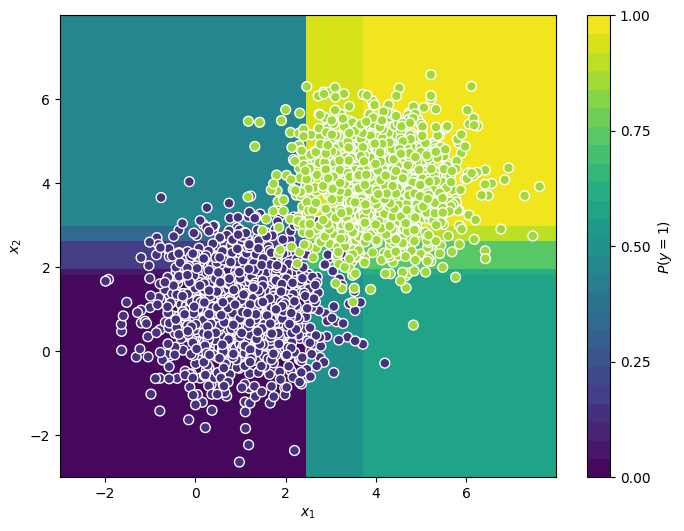

In [67]:
# Graph to depict probability predictions of the logit model

xx, yy = np.mgrid[-3:8:.01, -3:8:.01]  # create input data for our logit model using mgrid
grid = np.c_[xx.ravel(), yy.ravel()]   # then transform the data into our standard format

# Calculate logit probability predictions
probs = gbm_predict(stumps, pred_y_initial, grid, predict_class=False)

# Reshape to facilitate plotting
probs = probs.reshape(xx.shape)

# Plot logit predictions
f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs, 25,  vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

# Plott the actual data points
# We alter the format of the scatter plot to ensure that data points are visible
ax.scatter(data[:,0], data[:,1], c=labels, s=50, vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1);  
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");